In [4]:
# Import Required Libraries & Dataset

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# specify GPU
device = torch.device("cpu")

In [5]:
# Download and display

df = pd.read_csv("C:\\Users\\abcjv\\Downloads\\spotify_reviews.csv", usecols=['content', 'score'])
df.head(50000)

,content,score
0,It's good,4
1,"I love this app so much, I've been using Spoti...",5
2,Perfect,5
3,Best all around music streaming app I have use...,5
4,Are y'all fr gatekeeping the play button on so...,1
...,...,...
49995,This has been my go-to for listening to music ...,2
49996,"I just tried playing music on my playlist, but...",1
49997,"Horrible app, almost never plays the songs I w...",1
49998,usually a 5 star experience but since the last...,1


In [6]:
# Add sentiment value

def stars_to_sentiment(stars):
    if stars <= 2:
        return 0  # Negative
    elif stars == 3:
        return 1  # Neutral
    else:
        return 2  # Positive
    
if 'score' in df.columns:
    df['sentiment'] = df['score'].apply(stars_to_sentiment)
else:
    print("Error: Column 'score' not found in DataFrame.")

# Contraction words
contractions = {
    "isn't": "is not", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "hadn't": "had not", "isn't": "is not",
    "it's": "it is", "let's": "let us", "ma'am": "madam", "mightn't": "might not",
    "mustn't": "must not", "needn't": "need not", "needn't": "need not", "shan't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "wasn't": "was not", "weren't": "were not",
    "what's": "what is", "what'll": "what will", "what're": "what are", "what've": "what have",
    "where's": "where is", "where've": "where have", "who's": "who is", "who'll": "who will",
    "who're": "who are", "who've": "who have", "why's": "why is", "why're": "why are",
    "why've": "why have", "won't": "will not", "wouldn't": "would not", "you'd": "you would",
    "you'll": "you will", "you're": "you are", "you've": "you have"
}

# Important words
sentiment_important_words = {
    "not", "no", "very", "good", "bad", "excellent", "love", "hate", "great", "feel", "wish", "would", "should"
}

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to NOUN if unknown
    
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Expand contractions (assumes contractions dictionary is available)
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)

    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Define English stopwords
    stop_words = set(stopwords.words('english'))

    # Customize the stopwords list for sentiment analysis (add negations or important words)
    stop_words = stop_words - sentiment_important_words  # Remove sentiment important words from stopwords

    # POS tagging
    pos_tags = pos_tag(tokens)

    # Apply lemmatization based on POS tags and filter out stopwords and single-letter words
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags
        if word.isalnum() and word not in stop_words and len(word) > 1  # Filter single-letter words
    ]

    # Join the lemmatized tokens back into a single string
    return ' '.join(lemmatized_tokens)

# Test the function
df['processed_content'] = df['content'].apply(preprocess_text)
df.head()

,content,score,sentiment,processed_content
0,It's good,4,2,good
1,"I love this app so much, I've been using Spoti...",5,2,love app much ive use spotify year different a...
2,Perfect,5,2,perfect
3,Best all around music streaming app I have use...,5,2,best around music stream app use family plan g...
4,Are y'all fr gatekeeping the play button on so...,1,0,yall fr gatekeeping play button song


In [7]:
# check class distribution
df['sentiment'].value_counts(normalize = True)

sentiment
0    0.581073
2    0.276124
1    0.142803
Name: proportion, dtype: float64

In [8]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['processed_content'], df['sentiment'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [9]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

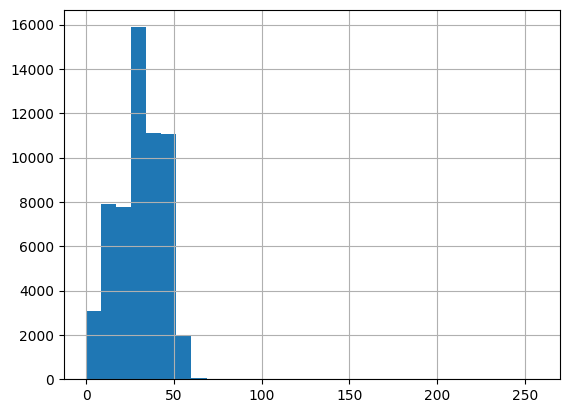

In [10]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [11]:
# tokenize and encode sequences in the training set
# tokens_train = tokenizer.batch_encode_plus(
#     train_text.tolist(),
#     max_length = 25,
#     pad_to_max_length=True,
#     truncation=True
# )

# # tokenize and encode sequences in the validation set
# tokens_val = tokenizer.batch_encode_plus(
#     val_text.tolist(),
#     max_length = 25,
#     pad_to_max_length=True,
#     truncation=True
# )

# # tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     max_length = 25,
#     pad_to_max_length=True,
#     truncation=True
# )

# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=25,
    padding='max_length',  # Replace pad_to_max_length=True
    truncation=True
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=25,
    padding='max_length',  # Replace pad_to_max_length=True
    truncation=True
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=25,
    padding='max_length',  # Replace pad_to_max_length=True
    truncation=True
)


In [12]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val["input_ids"])
val_mask = torch.tensor(tokens_val["attention_mask"])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test["input_ids"])
test_mask = torch.tensor(tokens_test["attention_mask"])
test_y = torch.tensor(test_labels.tolist())

In [13]:
# Data loader

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [14]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False


In [15]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [16]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [17]:
# optimizer from hugging face transformers
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

# Convert to NumPy array (ensure integer type)
train_labels_np = np.array(train_labels, dtype=int)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels_np), y=train_labels_np)

print("Class Weights:", class_weights)

Class Weights: [0.57364998 2.33428424 1.20717564]


c:\Users\abcjv\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [19]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [20]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [21]:
from tqdm import tqdm

# set initial loss to infinite
best_valid_loss = float('inf')

# defining epochs
epochs = 1

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# for each epoch
for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1} / {epochs}')
    
    # Train model with progress bar
    model.train()
    total_train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        
        model.zero_grad()
        
        # Get predictions and compute the loss
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        loss.backward()
        
        # Clip gradients and update model
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # Evaluate model with progress bar
    model.eval()
    total_valid_loss = 0
    with torch.no_grad():
        for step, batch in enumerate(tqdm(val_dataloader, desc="Evaluating", leave=False)):
            batch = [r.to(device) for r in batch]
            sent_id, mask, labels = batch
            
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_valid_loss += loss.item()
    
    avg_valid_loss = total_valid_loss / len(val_dataloader)
    
    # Save the best model
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Append training and validation losses
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    
    print(f'\nTraining Loss: {avg_train_loss:.3f}')
    print(f'Validation Loss: {avg_valid_loss:.3f}')



Epoch 1 / 1



Training Loss: 1.083
Validation Loss: 1.064


In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()


# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds, digits=5))

In [ ]:
def predict_feedback(feedback):
    # Tokenize and encode the input feedback
    tokens = tokenizer.encode_plus(
        feedback,
        max_length=25,  # same max_length used during training
        padding='max_length',  # pad to max length
        truncation=True,  # truncate if necessary
        return_tensors='pt'  # return as PyTorch tensors
    )

    # Extract the input ids and attention mask
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    # Make prediction using the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = outputs.detach().cpu().numpy()

    # Get the predicted class (0, 1, or 2)
    prediction = np.argmax(probs, axis=1)

    # Map the predicted class back to sentiment labels (if needed)
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_sentiment = sentiment_map[prediction[0]]

    return predicted_sentiment

In [ ]:
# Example of testing with actual feedback
feedback = "I love this product, it's amazing!"  # Example feedback text
predicted_sentiment = predict_feedback(feedback)
print(f"Predicted sentiment: {predicted_sentiment}")